In [1]:
import pandas as pd 
import geopandas as gpd
import numpy as np 

from sklearn.cluster import KMeans
from sklearn.cluster import Birch

import zipfile
import os 
import urllib.request 
import io
import requests
try:
    import urllib2 as urlib
except ImportError:
    import urllib as urlib
    
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
yr = ['94', '95', '96', '97', '98', '99', '00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14']

for i in yr: 
    url= 'https://github.com/fedhere/PUI2018_fb55/blob/master/HW12_fb55/zbp' + i + 'totals.zip?raw=true'
    
    urllib.request.urlretrieve(url, os.getenv('PUIDATA') + '/zbp' + i + '.zip')
    
    path= os.getenv('PUIDATA') + '/zbp' + i + '.zip'
    
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(os.getenv('PUIDATA'))
        
        
        #katie vorhees was very helpful with this code

In [3]:
df = pd.read_csv(os.getenv('PUIDATA') + '/zbp' + '94' + 'totals.txt')

df = df[['zip', 'est']]

yr2 = ['95', '96', '97', '98', '99', '00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14']

for i in yr2: 
    df_add = pd.read_csv(os.getenv('PUIDATA') + '/zbp' + i + 'totals.txt')
    
    df_add.columns = df_add.columns.str.lower()
    
    df_add = df_add[['zip', 'est']]
    
    df = df.join(df_add.set_index('zip'), on='zip', how='outer', rsuffix=i)

In [4]:
df.head()

,zip,est,est95,est96,est97,est98,est99,est00,est01,est02,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
0,1001.0,439.0,439.0,433.0,457.0,444.0,469.0,493.0,490.0,490.0,...,509.0,509.0,503.0,477.0,458.0,448.0,436.0,453.0,439.0,458.0
1,1002.0,450.0,467.0,487.0,500.0,490.0,558.0,563.0,587.0,566.0,...,589.0,582.0,596.0,584.0,571.0,570.0,558.0,572.0,572.0,560.0
2,1003.0,10.0,10.0,13.0,15.0,14.0,13.0,13.0,13.0,15.0,...,12.0,12.0,16.0,17.0,16.0,16.0,16.0,15.0,15.0,18.0
3,1004.0,47.0,48.0,47.0,41.0,31.0,35.0,48.0,37.0,23.0,...,31.0,30.0,20.0,18.0,18.0,21.0,19.0,16.0,16.0,13.0
4,1005.0,92.0,95.0,101.0,104.0,95.0,82.0,86.0,90.0,94.0,...,94.0,98.0,106.0,97.0,87.0,96.0,91.0,94.0,97.0,97.0


In [5]:
df['zip'] = df['zip'].astype(int)

# Downnloading NYC ZIP SHAPEFILE

In [6]:
url = 'https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip'

print("PUIdata", os.getenv("PUIDATA"))

print('Downloading shapefile...')
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")

z.extractall(path='/nfshome/mbh329/PUIdata/')

filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)

PUIdata /nfshome/mbh329/PUIdata
Done
['ZIP_CODE_040114.dbf', 'ZIP_CODE_040114.prj', 'ZIP_CODE_040114.shp', 'ZIP_CODE_040114.shx']


In [7]:
nycshp_zip = gpd.read_file('/nfshome/mbh329/PUIdata/ZIP_CODE_040114.shp')

nycshp_zip['ZIPCODE'] = pd.to_numeric(nycshp_zip['ZIPCODE'])


# Cleaning and MErging data

In [8]:
nycshp_merge = nycshp_zip.merge(df, left_on='ZIPCODE', right_on='zip')

In [9]:
nycshp_merge.columns

Index(['ZIPCODE', 'BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE',
       'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN',
       'geometry', 'zip', 'est', 'est95', 'est96', 'est97', 'est98', 'est99',
       'est00', 'est01', 'est02', 'est03', 'est04', 'est05', 'est06', 'est07',
       'est08', 'est09', 'est10', 'est11', 'est12', 'est13', 'est14'],
      dtype='object')

In [10]:
nyc =  nycshp_merge.drop(['BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE',
       'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN', 'geometry', 'zip'], axis=1)

In [11]:
nyc.head()

,ZIPCODE,est,est95,est96,est97,est98,est99,est00,est01,est02,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
0,11436,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,...,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0
1,11213,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,...,556.0,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0,772.0
2,11212,505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,577.0,...,587.0,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0,752.0
3,11225,381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,479.0,...,491.0,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0,696.0
4,11218,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,1228.0,...,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0,1736.0


In [12]:
nycclean = nyc.dropna() #drop nans from df

In [13]:
nycclean.set_index('ZIPCODE', inplace=True) #set index to zipcode # 

In [14]:
nycclean.head()

,est,est95,est96,est97,est98,est99,est00,est01,est02,est03,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
11436,51.0,50.0,53.0,51.0,51.0,58.0,65.0,57.0,78.0,74.0,...,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0
11213,406.0,420.0,433.0,456.0,476.0,473.0,477.0,493.0,546.0,569.0,...,556.0,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0,772.0
11212,505.0,494.0,502.0,527.0,519.0,541.0,520.0,527.0,577.0,581.0,...,587.0,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0,752.0
11225,381.0,387.0,388.0,410.0,416.0,409.0,417.0,422.0,479.0,488.0,...,491.0,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0,696.0
11218,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,1161.0,1180.0,1228.0,1247.0,...,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0,1736.0


In [15]:
nycclean.shape  #shape 

(243, 21)

## normalize

In [16]:
vals = ((nycclean.T - nycclean.mean(1)) / nycclean.std(1)).T  #f bianco code

In [17]:
cdict = {}  #renaming columns by year 
columnlist = list(range(1994,2015))
for i in range(len(columnlist)):
    cdict[vals.columns[i]] = columnlist[i]

vals.rename(columns=cdict, inplace=True)    
vals.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
11436,-1.296083,-1.347340,-1.193568,-1.296083,-1.296083,-0.937280,-0.578478,-0.988538,0.087870,-0.117160,...,0.292900,0.190385,0.395415,0.702960,0.805475,1.113020,1.266793,0.959248,1.164278,1.676853
11213,-1.433782,-1.305462,-1.186307,-0.975496,-0.792181,-0.819678,-0.783015,-0.636364,-0.150580,0.060232,...,-0.058923,0.023569,-0.058923,0.271044,0.536850,1.031799,1.022634,1.499252,1.765058,1.920875
11212,-1.077974,-1.210216,-1.114040,-0.813490,-0.909666,-0.645182,-0.897644,-0.813490,-0.212389,-0.164301,...,-0.092169,-0.296543,-0.092169,0.088161,0.629152,1.254297,1.422605,1.518781,1.639001,1.891464
11225,-1.223282,-1.159696,-1.149098,-0.915948,-0.852361,-0.926545,-0.841764,-0.788775,-0.184704,-0.089324,...,-0.057531,0.027251,0.186217,0.249804,0.493552,0.885668,1.065830,1.341371,1.871258,2.115007
11218,-1.474935,-1.336988,-1.180649,-1.061095,-0.863371,-0.720826,-0.665648,-0.578281,-0.357567,-0.270200,...,0.120649,0.116050,0.327569,0.419533,0.695427,0.773596,0.998909,1.375964,1.753018,1.978331


In [18]:
nc = 5 #this is # of clusters chosen randomly 
km = KMeans(n_clusters=nc, random_state=444).fit(vals)

In [19]:
km

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=444, tol=0.0001,
    verbose=0)

In [20]:
km.labels_.shape

(243,)

In [21]:
km.labels_ #zip code 

array([4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 0, 0, 2, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4,
       4, 2, 4, 2, 4, 4, 2, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4,
       2, 4, 4, 4, 4, 2, 2, 4, 4, 4, 2, 2, 2, 2, 1, 2, 4, 2, 4, 4, 1, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 0, 1, 2, 2, 3, 4, 1, 4, 2, 4, 4, 2,
       4, 4, 2, 1, 3, 4, 4, 1, 4, 1, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 2, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2,
       2, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 2, 2, 2, 4, 2, 4,
       0, 4, 4, 4, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 3, 4, 4, 4, 4, 4, 4,
       4, 3, 1, 1, 0, 0, 1, 4, 1, 1, 2, 4, 4, 3, 1, 0, 0, 1, 1, 1, 2, 1, 1,
       1, 4, 1, 1, 4, 0, 1, 4, 1, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 4,
       0, 3, 3, 1, 1, 2, 2, 4, 3, 3, 0, 3, 2], dtype=int32)

In [22]:
vals['cluster'] = km.labels_ #creating cluster column 


In [23]:
vals = pd.DataFrame(vals)

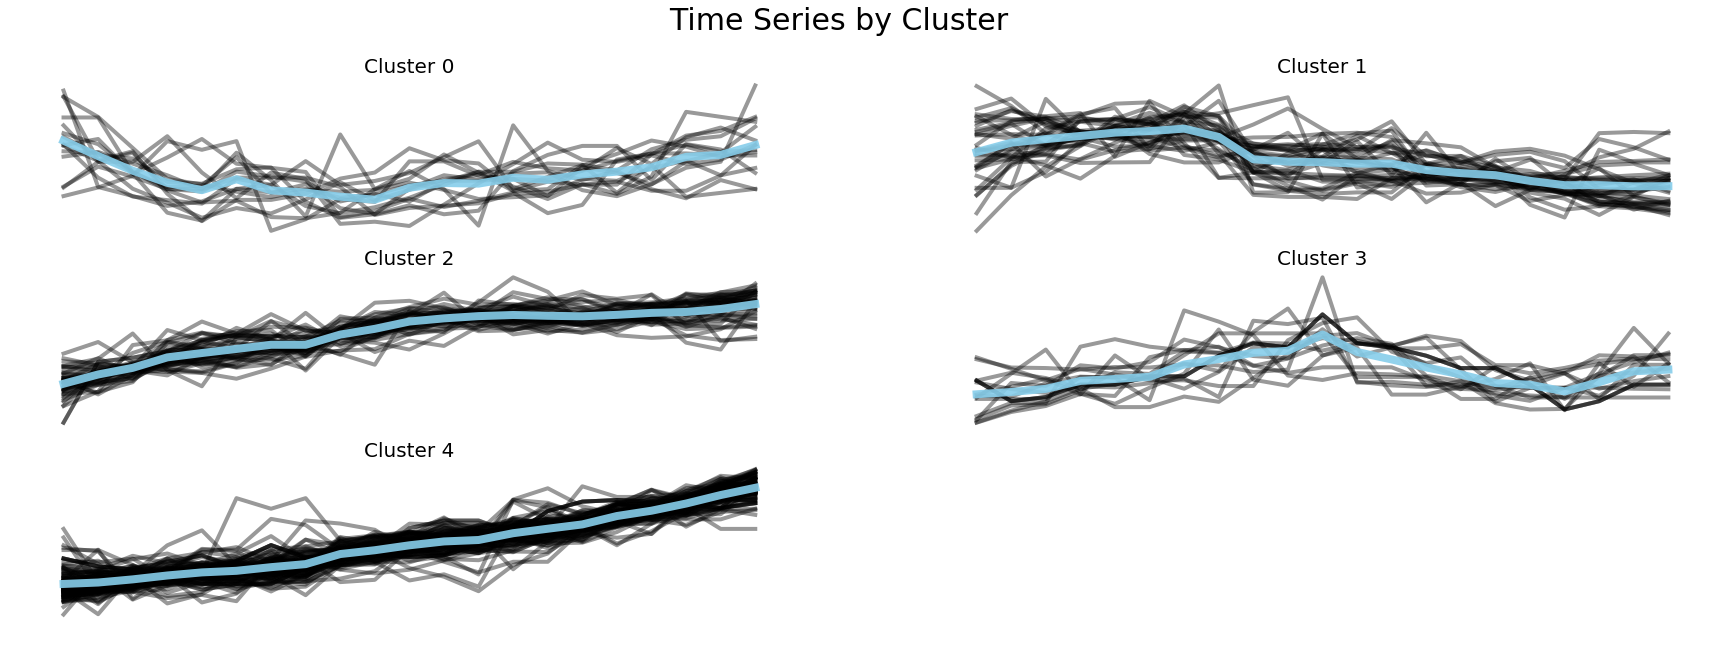

In [24]:
plt.figure(figsize=(30,10)) 
plt.suptitle('Time Series by Cluster', fontsize=30)
N=320
for x in range(5):        #cyrus helped me with this code w/o him i could never have done this
    N+=1
    plt.subplot(N)
    seg = vals[vals.cluster == x]
    for i in range(len(seg)):
        plt.plot(range(1994,2015), seg.iloc[i][0:-1], c='k', alpha=0.4, lw=4)
    plt.plot(range(1994,2015), seg.mean()[0:-1], c='skyblue', alpha=0.9, lw=8)
    plt.axis('off')
    plt.title('Cluster {}'.format(x), fontsize=20)

Text(0.5,1,'Cluster 4')

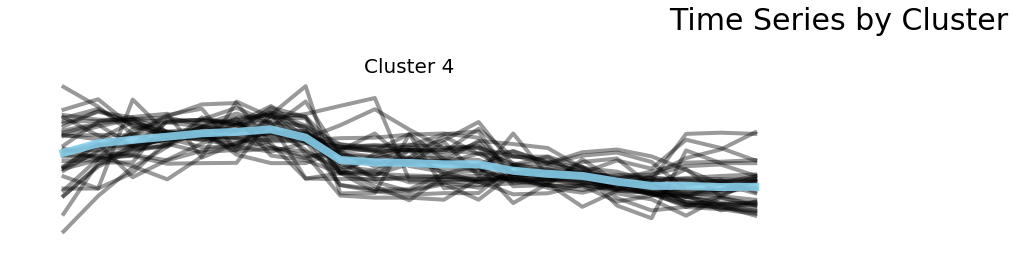

In [25]:
plt.figure(figsize=(30,10))
plt.suptitle('Time Series by Cluster', fontsize=30)
N=321
plt.subplot(N)
seg = vals[vals.cluster == 1]
for i in range(len(seg)):
    plt.plot(range(1994,2015), seg.iloc[i][0:-1], c='k', alpha=0.4, lw=4)
plt.plot(range(1994,2015), seg.mean()[0:-1], c='skyblue', alpha=0.9, lw=8)
plt.axis('off')
plt.title('Cluster {}'.format(x), fontsize=20)

In [26]:
seg.mean()[0:-1]

1994    0.274678
1995    0.617233
1996    0.748553
1997    0.862297
1998    0.984689
1999    1.039467
2000    1.130373
2001    0.826945
2002    0.012162
2003   -0.075462
2004   -0.096737
2005   -0.147389
2006   -0.145769
2007   -0.380674
2008   -0.493293
2009   -0.569397
2010   -0.776861
2011   -0.933500
2012   -0.931536
2013   -0.976435
2014   -0.969342
dtype: float64

In [27]:
seg

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,cluster
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
11363,-1.030736,-1.030736,2.216083,0.979199,1.133810,0.206147,-0.103074,-0.103074,0.360758,0.979199,...,-0.566905,0.979199,-0.566905,-0.412294,-1.649178,-2.113009,0.360758,-0.103074,-0.103074,1
10021,0.351024,0.380379,0.476057,0.780484,0.791357,0.719599,0.745693,0.725035,0.807665,0.827236,...,0.823974,-0.482891,-0.645977,-0.804714,-0.967801,-1.247222,-1.631018,-1.732132,-1.834333,1
10017,1.233528,1.807166,1.347469,1.021360,0.887773,0.542019,0.840625,0.836696,-0.235929,-0.373445,...,0.247342,-0.463812,-0.389161,-0.793851,-0.931367,-1.249618,-1.320340,-1.367489,-1.599301,1
10010,-0.589198,-1.026701,-0.452478,0.682297,1.229177,1.106129,1.926448,1.584648,0.313154,-0.233726,...,-0.206382,-1.559909,-0.848965,-1.696628,-1.108733,-0.548182,0.080730,0.395186,1.024097,1
10013,-0.208985,0.549121,0.489963,0.803284,0.476816,0.496536,1.668753,2.705124,-1.205918,-1.190580,...,-0.901360,-0.846584,-0.699783,-0.842202,-0.691019,-0.403990,-0.086286,-0.051229,0.007930,1
10038,-0.275537,0.296869,0.197320,-0.001778,0.346644,0.607960,1.093261,0.794614,1.279915,1.864765,...,0.471080,-0.947493,-0.897718,0.035553,-0.798169,-0.847944,-1.544786,-1.594561,-1.644335,1
10006,1.576901,0.902719,0.525634,0.765597,1.222670,1.554047,1.645462,1.176962,0.125695,-0.697036,...,-0.559914,-0.685609,-0.891292,-1.085548,-0.914145,-1.016987,-0.834158,-0.811304,-0.777024,1
10019,-1.956466,-0.083589,-0.076244,1.488159,1.444092,1.363301,1.018104,1.076861,-0.112967,-0.597712,...,1.150307,0.122061,0.136750,-0.619746,-1.097146,-1.192626,-1.346863,-0.832740,-0.568333,1
10111,-1.099835,0.063610,1.140874,1.399417,1.485599,1.916504,1.356327,1.011602,0.235972,-0.108752,...,-0.281115,-0.798201,-0.798201,-0.496567,-0.755111,-0.884383,-1.229107,-1.099835,-1.013654,1


In [28]:
seg.iloc[1]

1994       0.351024
1995       0.380379
1996       0.476057
1997       0.780484
1998       0.791357
1999       0.719599
2000       0.745693
2001       0.725035
2002       0.807665
2003       0.827236
2004       0.938134
2005       0.979450
2006       0.823974
2007      -0.482891
2008      -0.645977
2009      -0.804714
2010      -0.967801
2011      -1.247222
2012      -1.631018
2013      -1.732132
2014      -1.834333
cluster    1.000000
Name: 10021, dtype: float64

Figure 1: In this figure, we have a KM Means Time Series by NYC zip with clusters of Business establishments.. Each cluster represents the # of observations (standardized) based on the mean(blue line) and the distance/similarity of each observation to the mean. The two cluster models with observations nearest the mean are cluster 2 & 4. Each cluster represents a different partion of the data based on the km means model in sklearn.

This is probably not the best representation of a cluster for this data as clusters need to be refined constantly and it is hard to define clusters without any domain knowledge. 

In [29]:
nycshp_merge.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,82.0,80.0,84.0,90.0,92.0,98.0,101.0,95.0,99.0,109.0
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,...,556.0,565.0,556.0,592.0,621.0,675.0,674.0,726.0,755.0,772.0
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,...,587.0,570.0,587.0,602.0,647.0,699.0,713.0,721.0,731.0,752.0
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,...,491.0,499.0,514.0,520.0,543.0,580.0,597.0,623.0,673.0,696.0
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,...,1332.0,1331.0,1377.0,1397.0,1457.0,1474.0,1523.0,1605.0,1687.0,1736.0


# MAPPING NYC CLUSTERS

In [30]:
nycmap = nycshp_merge.merge(vals[["cluster"]], left_on="ZIPCODE", right_index=True, how="left")

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


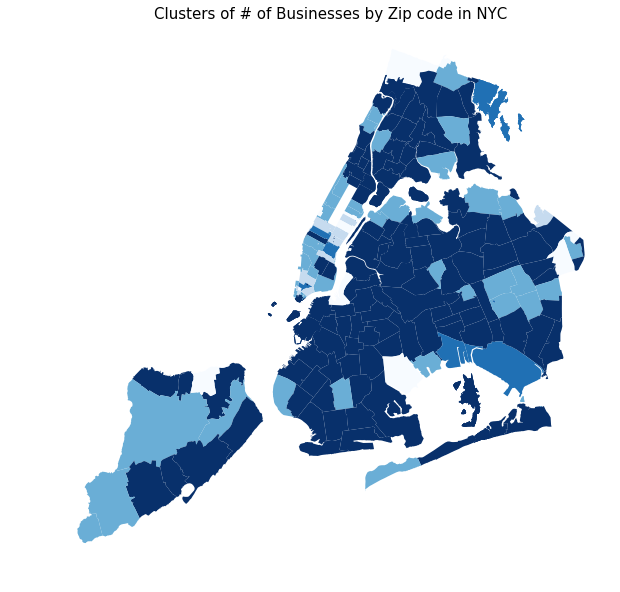

In [31]:
f, ax = plt.subplots(figsize=(10,10))

ax.set_title("Clusters of # of Businesses by Zip code in NYC", fontsize=15)

nycmap.plot(column='cluster', cmap='Blues',linewidth=0.2,ax=ax,\
                scheme='equal_interval', legend=False)

ax.set_axis_off()

### Figure 2: In this figure we have mapped the Kmeans clustering of business establsishments by zipcode over 20 years within the 5 boroughs of NYC. color variance in the choropleth map is based on similiarity (like colors) and dissimilarity (unlike colors) between zip codes in the # of establishments they have contained in each individual polygons (zip). Manhattan has the highest cluster concentration of businesses per zip due to the high rate of CBD's located  there. 

# Different kinda Cluster Mapping

In [32]:
vals2 = vals.drop(['cluster'], axis=1) #creating vals2 

In [33]:
vals2

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
11436,-1.296083,-1.347340,-1.193568,-1.296083,-1.296083,-0.937280,-0.578478,-0.988538,0.087870,-0.117160,...,0.292900,0.190385,0.395415,0.702960,0.805475,1.113020,1.266793,0.959248,1.164278,1.676853
11213,-1.433782,-1.305462,-1.186307,-0.975496,-0.792181,-0.819678,-0.783015,-0.636364,-0.150580,0.060232,...,-0.058923,0.023569,-0.058923,0.271044,0.536850,1.031799,1.022634,1.499252,1.765058,1.920875
11212,-1.077974,-1.210216,-1.114040,-0.813490,-0.909666,-0.645182,-0.897644,-0.813490,-0.212389,-0.164301,...,-0.092169,-0.296543,-0.092169,0.088161,0.629152,1.254297,1.422605,1.518781,1.639001,1.891464
11225,-1.223282,-1.159696,-1.149098,-0.915948,-0.852361,-0.926545,-0.841764,-0.788775,-0.184704,-0.089324,...,-0.057531,0.027251,0.186217,0.249804,0.493552,0.885668,1.065830,1.341371,1.871258,2.115007
11218,-1.474935,-1.336988,-1.180649,-1.061095,-0.863371,-0.720826,-0.665648,-0.578281,-0.357567,-0.270200,...,0.120649,0.116050,0.327569,0.419533,0.695427,0.773596,0.998909,1.375964,1.753018,1.978331
11226,-1.152003,-1.128719,-1.105435,-0.957970,-0.663039,-0.810504,-0.857072,-1.113196,-0.469006,-0.274973,...,0.167423,-0.096462,0.167423,0.431308,0.539967,0.772807,1.098782,1.564462,1.774018,1.983574
11219,-1.713507,-1.549727,-1.380299,-1.112038,-0.928491,-0.733649,-0.502098,-0.293137,-0.239485,-0.053114,...,0.243384,0.265975,0.378927,0.393046,0.650011,0.915448,1.101819,1.240185,1.468912,1.765411
11210,-1.248641,-1.025385,-1.070036,-0.768640,-0.668175,-1.103525,-0.924920,-0.657012,-0.400267,-0.545384,...,0.001595,0.202525,0.135549,0.347642,0.492759,1.285319,1.731832,1.463924,1.430436,1.687181
11230,-1.967255,-1.715663,-1.380207,-1.259070,-1.063387,-0.760545,-0.373838,-0.122246,-0.019746,0.189914,...,0.450825,0.469461,0.469461,0.520711,0.702417,0.898099,1.065827,0.772303,1.219578,1.475829


In [34]:
nc2 = 4 #this is # of clusters chosen randomly 
brc = Birch(branching_factor=50, n_clusters=nc2, threshold=0.5, compute_labels=True).fit(vals2)

#Birch(threshold=0.5, branching_factor=50, n_clusters=3, compute_labels=True, copy=True)
#(branching_factor=50, n_clusters=None, threshold=0.5,
#... compute_labels=True)

In [35]:
brc.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 1, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 3, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 3, 1, 1, 2, 2, 1, 0, 1, 1, 0, 0, 0, 3, 1, 2, 2, 1, 1, 1, 0, 1, 3,
       1, 0, 1, 1, 0, 2, 2, 0, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 0,
       2, 3, 3, 3, 1, 0, 0, 0, 3, 3, 2, 3, 0])

In [36]:
vals2['brc_cluster'] = brc.labels_

# Birch Cluster Time Series

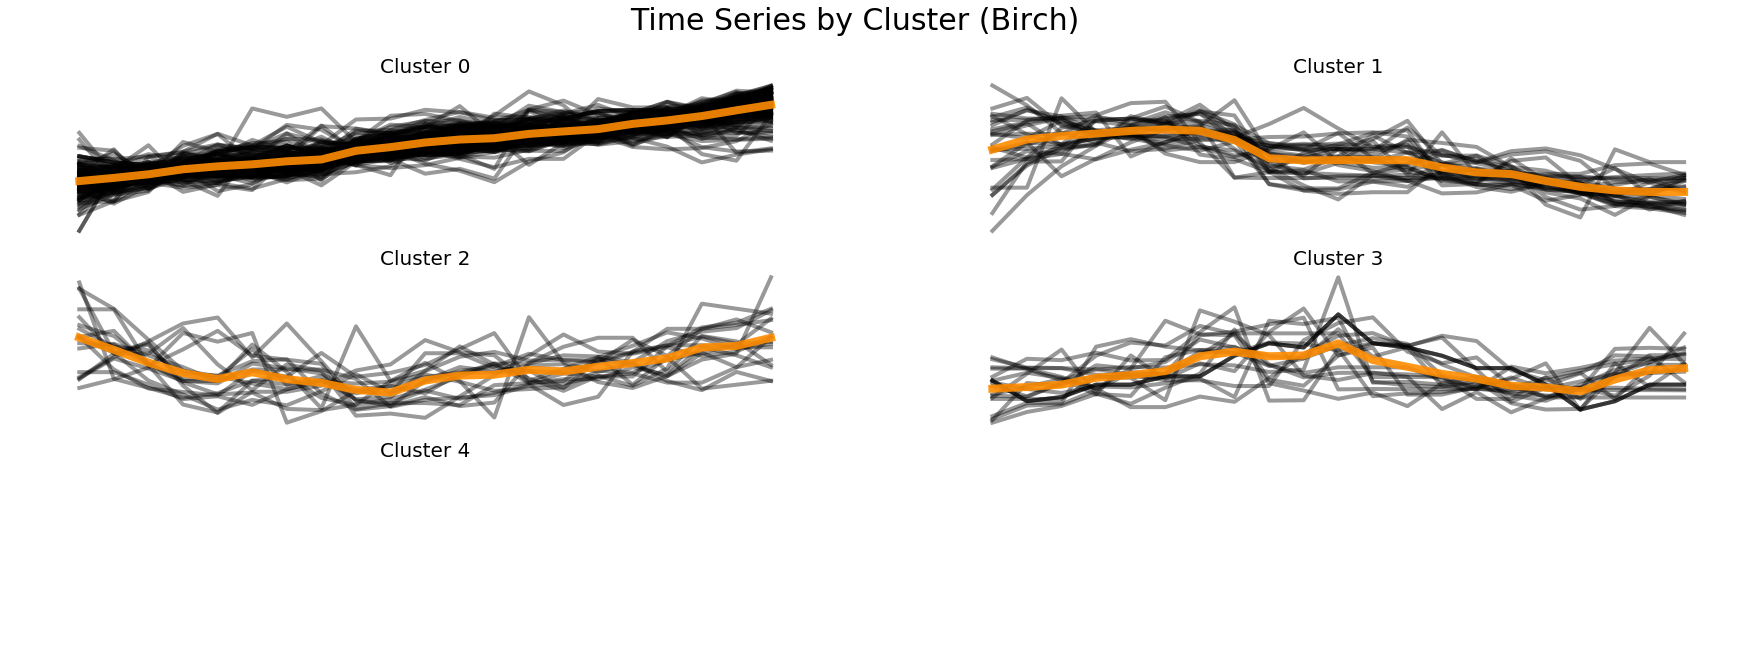

In [37]:
plt.figure(figsize=(30,10))
plt.suptitle('Time Series by Cluster (Birch)', fontsize=30)
N=320
for x in range(5):
    N+=1
    plt.subplot(N)
    seg = vals2[vals2.brc_cluster == x]
    for i in range(len(seg)):
        plt.plot(range(1994,2015), seg.iloc[i][0:-1], c='k', alpha=0.4, lw=4)
    plt.plot(range(1994,2015), seg.mean()[0:-1], c='DarkOrange', alpha=0.9, lw=8)
    plt.axis('off')
    plt.title('Cluster {}'.format(x), fontsize=20)

## Figure 3: These are 4 Birch Clusters based on the standarized zip code data in NYC with clusters of Business establishments. the orange line represents the mean of the data and the black lines represent the distance of the # of  businesses (per zip code) based on the centroid that scikit learn chooses randomnly which is why you see 4 different clusters. 

In [38]:
vals2.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,brc_cluster
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
11436,-1.296083,-1.347340,-1.193568,-1.296083,-1.296083,-0.937280,-0.578478,-0.988538,0.087870,-0.117160,...,0.190385,0.395415,0.702960,0.805475,1.113020,1.266793,0.959248,1.164278,1.676853,0
11213,-1.433782,-1.305462,-1.186307,-0.975496,-0.792181,-0.819678,-0.783015,-0.636364,-0.150580,0.060232,...,0.023569,-0.058923,0.271044,0.536850,1.031799,1.022634,1.499252,1.765058,1.920875,0
11212,-1.077974,-1.210216,-1.114040,-0.813490,-0.909666,-0.645182,-0.897644,-0.813490,-0.212389,-0.164301,...,-0.296543,-0.092169,0.088161,0.629152,1.254297,1.422605,1.518781,1.639001,1.891464,0
11225,-1.223282,-1.159696,-1.149098,-0.915948,-0.852361,-0.926545,-0.841764,-0.788775,-0.184704,-0.089324,...,0.027251,0.186217,0.249804,0.493552,0.885668,1.065830,1.341371,1.871258,2.115007,0
11218,-1.474935,-1.336988,-1.180649,-1.061095,-0.863371,-0.720826,-0.665648,-0.578281,-0.357567,-0.270200,...,0.116050,0.327569,0.419533,0.695427,0.773596,0.998909,1.375964,1.753018,1.978331,0


In [39]:
nycmap_brc = nycshp_merge.merge(vals2[["brc_cluster"]], left_on="ZIPCODE", \
                                right_index=True, how="left")

# Birch Cluster Map of NYC

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


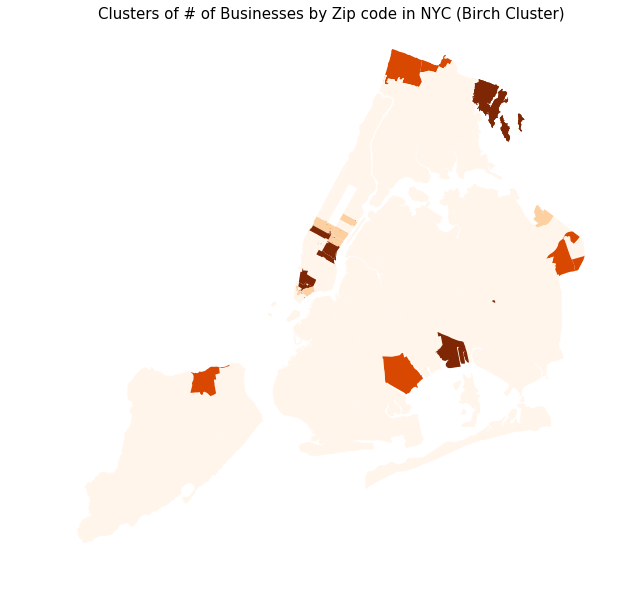

In [40]:
#class sklearn.cluster.AgglomerativeClustering(n_clusters=2, affinity=’euclidean’, memory=None, 
#connectivity=None, compute_full_tree=’auto’, linkage=’ward’, pooling_func=’deprecated’)[source]


f, ax = plt.subplots(figsize=(10,10))

ax.set_title("Clusters of # of Businesses by Zip code in NYC (Birch Cluster)", fontsize=15)

nycmap_brc.plot(column='brc_cluster', cmap='Oranges',linewidth=0.2,ax=ax,\
                scheme='equal_interval', legend=False)

ax.set_axis_off()

### Figure 4: clustering of business establsishments by zipcode over 20 years within the 5 boroughs of NYC. color variance in the choropleth map is based on similiarity (like colors) and dissimilarity (unlike colors) between zip codes in the # of establishments they have contained in each individual polygons (zip).

### Areas of similar time evolution (the birch cluster) of # of business include midtown manhattan and the financial district/ northern staten island and east ny/canarsie, riverdale, and western queens/ and pelham bay/howard beach /midtown manhattan.

# 6/7 : Interpretation of two clusters:

### Both clustering algorithms that KM means and Birch are very different. Kmeans seems to cluster at a much smaller scale of similiarity/dissimilairty while the birch clustering method highlights zip codes with very high # of business variance over time. For example, in the two maps you see more variance in the Kmeans map in areas outside of "designated" Central business districts (ie midtown manhattan and the financial district) than you see in areas you would assume would have less # of businesses and therefore less variance in the data. 

### Areas of similar time evolution (the birch cluster) of # of business include midtown manhattan and the financial district/ northern staten island and east ny/canarsie, riverdale, and western queens/ and pelham bay/howard beach /midtown manhattan. Areas of similar time evolution are harder to extract with the kmeans cluster but you see a lot of variance in similar zipcodes with the birch cluster.

### The birch cluster might be more useful if you are looking for patterns in data over a larger scale while the kmeans could be better for localized patterns(?). 
